# IGF signaling pathway simulations

In [178]:
# Load packages
from MScausality.SCM_numpyro import SCM
from MScausality.simulation import simulate_data
from MScausality.dataProcess import dataProcess

import pandas as pd
import numpy as np
from sklearn import linear_model

import networkx as nx
import y0
from y0.algorithm.simplify_latent import simplify_latent_dag
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Variable

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

## Build network

In [2]:
def build_igf_network(cell_confounder):
    """
    Create IGF graph in networkx
    
    cell_confounder : bool
        Whether to add in cell type as a confounder
    """
    graph = nx.DiGraph()

    ## Add edges
    graph.add_edge("EGF", "SOS")
    graph.add_edge("EGF", "PI3K")
    graph.add_edge("IGF", "SOS")
    graph.add_edge("IGF", "PI3K")
    graph.add_edge("SOS", "Ras")
    graph.add_edge("Ras", "PI3K")
    graph.add_edge("Ras", "Raf")
    graph.add_edge("PI3K", "Akt")
    graph.add_edge("Akt", "Raf")
    graph.add_edge("Raf", "Mek")
    graph.add_edge("Mek", "Erk")
    
    if cell_confounder:
        graph.add_edge("cell_type", "Ras")
        graph.add_edge("cell_type", "Raf")
        graph.add_edge("cell_type", "Mek")
        graph.add_edge("cell_type", "Erk")
    
    return graph

def build_admg(graph, cell_confounder=False, cell_latent=False):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk", "EGF", "IGF"]
    obs_nodes = ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                 "Mek", "Erk"]
    latent_nodes = ["EGF", "IGF"]
    
    ## Add in cell_type if included
    if cell_confounder:
        all_nodes.append("cell_type")
        if cell_latent:
            latent_nodes.append("cell_type")
        else:
            obs_nodes.append("cell_type")
        
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    ## Use y0 to build ADMG
    simplified_graph = simplify_latent_dag(graph.copy(), "hidden")
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

In [128]:
cell_type_graph = build_igf_network(cell_confounder=True)
bulk_graph = build_igf_network(cell_confounder=False)
y0_graph_bulk = build_admg(bulk_graph, cell_confounder=False)

<Axes: >

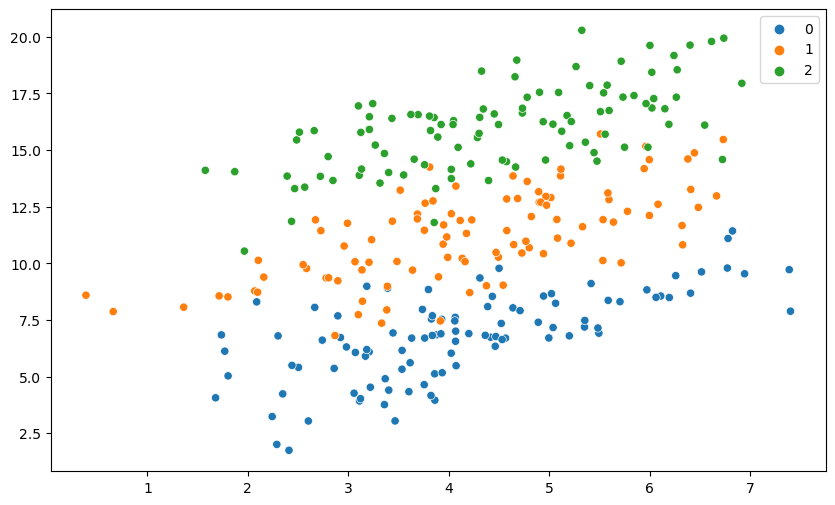

In [37]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(x=cell_sim["Protein_data"]["Raf"], y=cell_sim["Protein_data"]["Erk"],
               hue=[str(i) for i in cell_sim["Protein_data"]["cell_type"]])


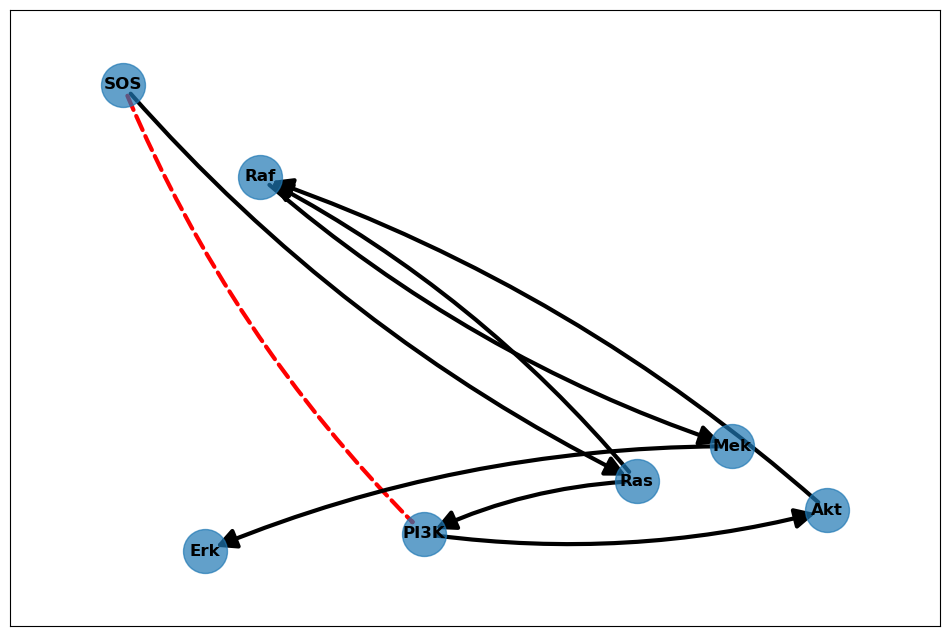

In [134]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    pos = nx.random_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
plot_latent_graph(y0_graph, figure_size=(12, 8))

## Ground truth invervention

Generate interventional data using the ground truth network for comparison.

In [65]:
## Coefficients for relations
cell_coef = {'EGF': {'intercept': 18., "error": 3},
              'IGF': {'intercept': 17., "error": 3},
              'SOS': {'intercept': -4, "error": 1, 
                      'EGF': 0.6, 'IGF': 0.6,},
              'Ras': {'intercept': 5, "error": 1, 'SOS': .5, "cell_type" : [3, 0, -3]},
              'PI3K': {'intercept': 1.6, "error": 1, 
                       'EGF': .5, 'IGF': 0.5, 'Ras': .5,},
              'Akt': {'intercept': 2., "error": 1, 'PI3K': 0.75, },
              'Raf': {'intercept': 2, "error": 1,
                      'Ras': 0.8, 'Akt': -.4, "cell_type" : [-2, 0, 2]},
              'Mek': {'intercept': 3., "error": 1, 'Raf': 0.75, "cell_type" : [-2, 0, 2]},
              'Erk': {'intercept': 4., "error": 1, 'Mek': 1.2, "cell_type" : [-2, 0, 2]}
             }

In [69]:
def obs_gt_sim(coef, n, cell_type, n_cells=1):
    
    """
    Observational ground truth simulation of network
    """
    
    if cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.array(coef["Ras"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    return({"EGF" : EGF, "IGF" : IGF, "SOS" : SOS, 
            "Ras" : Ras, "PI3K": PI3K, "Akt" : Akt,
            "Raf" : Raf, "Mek" : Mek, "Erk" : Erk, "cell_type" : cell_type})

def int_gt_sim(coef, n, inc_cell_type, n_cells=1):

    """
    Ras interventional simulation of network (Ras=10 vs Ras=20)
    """
    
    if inc_cell_type:
        cell_type = np.repeat([i for i in range(n_cells)], n//n_cells)
        if len(cell_type) < n:
            cell_type = np.append(cell_type, n_cells-1)
            
    EGF = np.random.normal(coef["EGF"]["intercept"], 3, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 3, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 10
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk10 = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 20
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.array(coef["Raf"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.array(coef["Mek"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    Erk20 = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.array(coef["Erk"]["cell_type"])[cell_type] + np.random.normal(0, 1., n)
    
    int_data = [Erk10, Erk20]
    if inc_cell_type:
        int_data.append(cell_type)
        
    return int_data

gt_int_cell = int_gt_sim(cell_coef, 10000, inc_cell_type=True, n_cells=3)

(-5.0, 30.0)

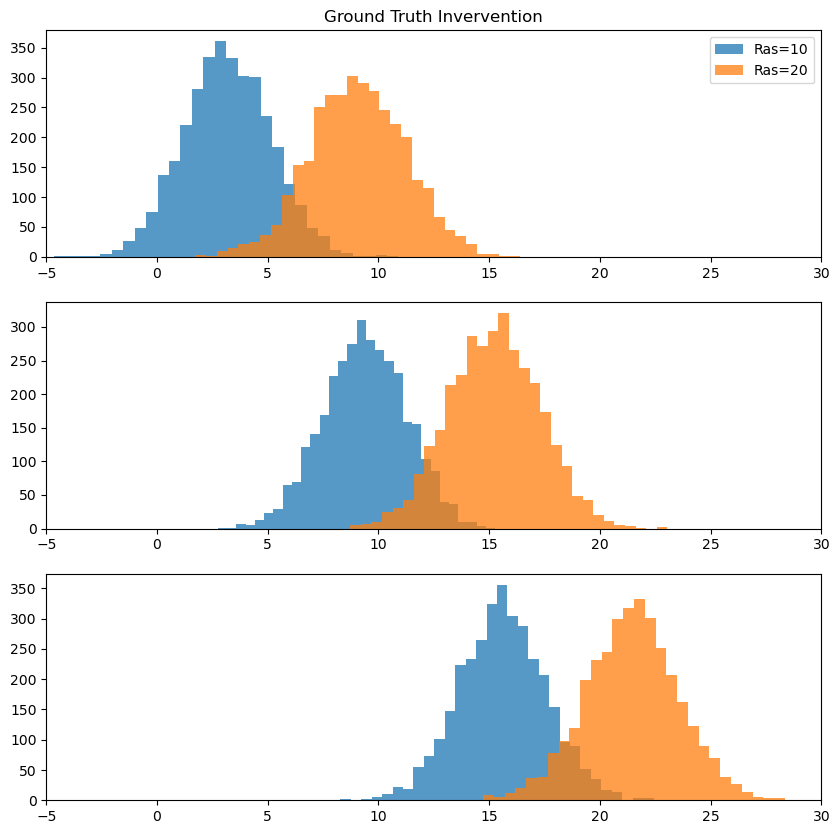

In [70]:
fig, ax = plt.subplots(3,1,figsize=(10,10))

ax[0].hist(gt_int_cell[0][gt_int_cell[2] == 0], label="Ras=10", alpha=.75, bins=30)
ax[0].hist(gt_int_cell[1][gt_int_cell[2] == 0], label="Ras=20", alpha=.75, bins=30)
ax[0].legend()
ax[1].hist(gt_int_cell[0][gt_int_cell[2] == 1], label="Ras=10", alpha=.75, bins=30)
ax[1].hist(gt_int_cell[1][gt_int_cell[2] == 1], label="Ras=20", alpha=.75, bins=30)
ax[2].hist(gt_int_cell[0][gt_int_cell[2] == 2], label="Ras=10", alpha=.75, bins=30)
ax[2].hist(gt_int_cell[1][gt_int_cell[2] == 2], label="Ras=20", alpha=.75, bins=30)

ax[0].set_title("Ground Truth Invervention")
ax[0].set_xlim(-5, 30)
ax[1].set_xlim(-5, 30)
ax[2].set_xlim(-5, 30)

In [164]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 0]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 0])

5.891455277398267

In [165]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 1]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 1])

5.846121343442617

In [166]:
np.mean(gt_int_cell[1][gt_int_cell[2] == 2]) - np.mean(gt_int_cell[0][gt_int_cell[2] == 2])

5.842883202612008

## Cell Type - Bulk

### Simulate Data

In [148]:
cell_sim = simulate_data(cell_type_graph, coefficients=cell_coef, include_missing=True, 
                         cell_type=True, n_cells=3, n=300, seed=0)

simulating data...
adding feature level data...
masking data...


Save feature level data to csvs to run data processing in MSstats in R. Wrapper for dataProcess functionality is being added to MScausality but is not currently available. For information on the R code to run please see the documentation for the dataProcess.py function (i.e., ?dataProcess)

In [9]:
?dataProcess

Signature: dataProcess(data, normalization='equalizeMedians', MBimpute=True)
Docstring:
Implementation of MSstats dataProcess function in Python.

Currently unavailable, to convert simualated data into MSstats format and run dataProcess function,
execute the following code in R:

library(MSstats)
library(tidyverse)

data = read.csv("sim_feature_level_data.csv")
data = data %>% select(Protein, Feature, Replicate, Obs_Intensity)
data = data %>% rename(ProteinName=Protein, PeptideSequence=Feature,
                       BioReplicate=Replicate, Intensity=Obs_Intensity)

data$PrecursorCharge = 2
data$FragmentIon = NA
data$ProductCharge= NA
data$IsotopeLabelType = "L"
data$Condition = "Obs"
data$Run = data$BioReplicate
data$Fraction = 1
data$PeptideSequence  = paste(data$ProteinName, data$PeptideSequence , sep="_")
data$Run = paste(data$Run, data$Condition, sep="_")
data$Intensity = 2**data$Intensity

processed_data = dataProcess(data, normalization="equalizeMedians", MBimpute=TRUE)
processe

In [149]:
cell_sim["Feature_data"].to_csv("../data/IGF_pathway/cell_type_feature_data.csv", index=False)

In [150]:
cell_sim_protein_data = pd.read_csv("../data/IGF_pathway/cell_sim_protein_data.csv")
cell_sim_protein_data.loc[:, "cell_type"] = cell_sim["Protein_data"]["cell_type"].astype(str)

### Initial Analysis

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12')])

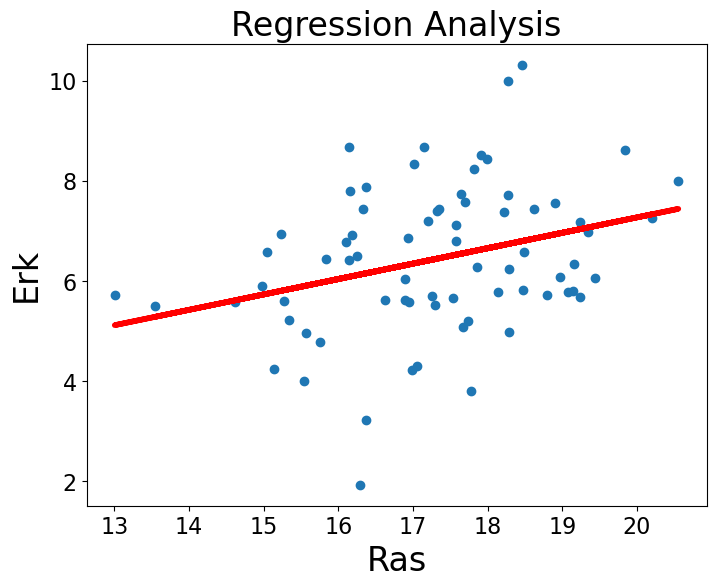

In [151]:
fig, ax = plt.subplots(figsize=(8,6))

plot_data = cell_sim_protein_data.dropna()
x = plot_data[plot_data["cell_type"] == "0"]["Ras"]
y = plot_data[plot_data["cell_type"] == "0"]["Erk"]

ax.scatter(x, y)
m, b = np.polyfit(x.values, y.values, 1)
ax.plot(x, m*x + b, color="red", lw=4)

ax.set_title("Regression Analysis", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0.0, '0.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 5.0, '5.0'),
  Text(0, 7.5, '7.5'),
  Text(0, 10.0, '10.0'),
  Text(0, 12.5, '12.5'),
  Text(0, 15.0, '15.0'),
  Text(0, 17.5, '17.5'),
  Text(0, 20.0, '20.0'),
  Text(0, 22.5, '22.5')])

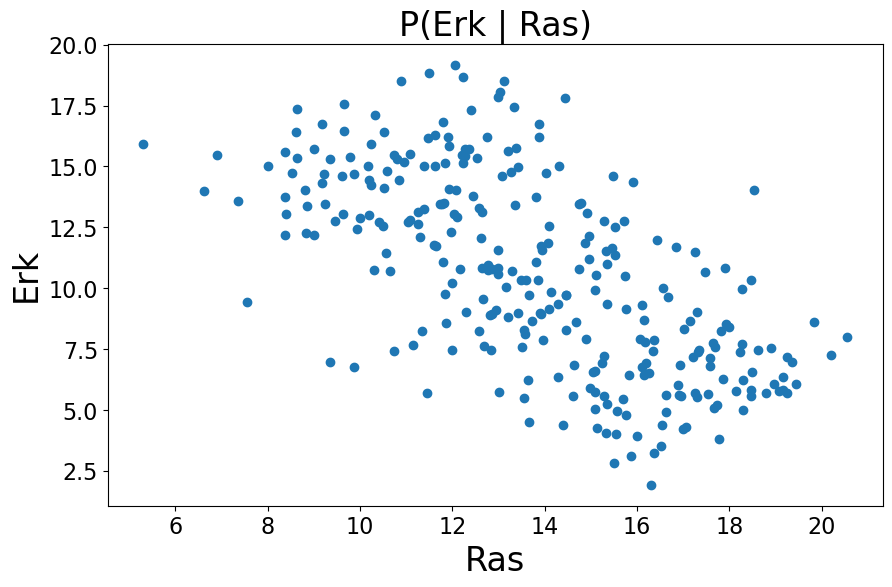

In [152]:
fig, ax = plt.subplots(figsize=(10,6))

x = cell_sim_protein_data["Ras"]
y = cell_sim_protein_data["Erk"]

ax.scatter(x, y)

ax.set_title("P(Erk | Ras)", size=24)
ax.set_xlabel("Ras", size=24)
ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

### Run inference

In [155]:
scm = SCM(cell_sim_protein_data.iloc[:,1:-1], y0_graph_bulk)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [134]:
scm.summary_stats

{'Akt_PI3K_coef': OrderedDict([('mean', 0.7542848),
              ('std', 0.026954724),
              ('median', 0.7585183),
              ('5.0%', 0.7064711),
              ('95.0%', 0.79915804),
              ('n_eff', 150.65304105179032),
              ('r_hat', 1.026493578289877)]),
 'Akt_intercept': OrderedDict([('mean', 1.8664734),
              ('std', 0.6811156),
              ('median', 1.8375188),
              ('5.0%', 0.7032434),
              ('95.0%', 3.0415144),
              ('n_eff', 169.20673115101766),
              ('r_hat', 1.0217753393263178)]),
 'Akt_scale': OrderedDict([('mean', 1.0262662),
              ('std', 0.06840365),
              ('median', 1.0133795),
              ('5.0%', 0.9315871),
              ('95.0%', 1.1416193),
              ('n_eff', 19.691083551061094),
              ('r_hat', 1.0907581359517424)]),
 'Erk_Mek_coef': OrderedDict([('mean', 1.7639937),
              ('std', 0.063249536),
              ('median', 1.7642694),
              ('5.0

In [159]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

1.1208534

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350'),
  Text(0, 400.0, '400')])

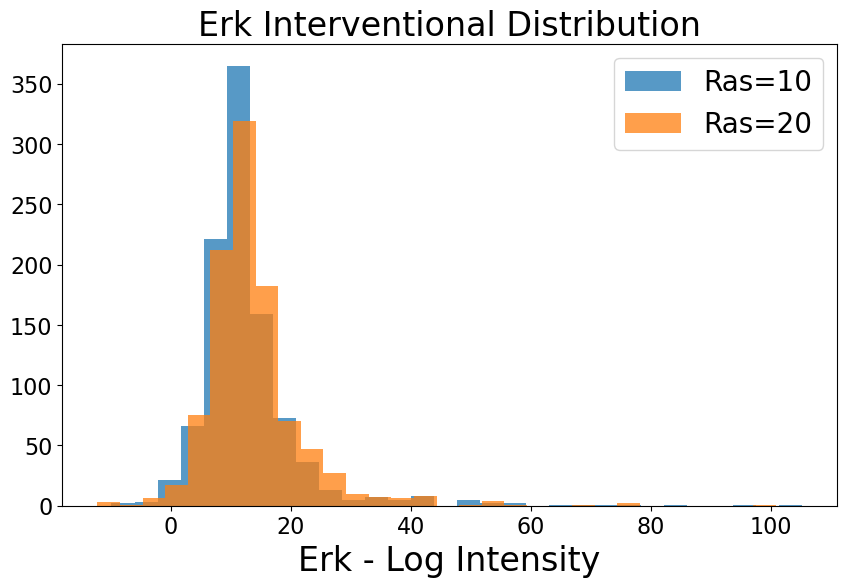

In [163]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")

ax.legend(fontsize=20)
ax.set_title("Erk Interventional Distribution", size=24)
ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Cell Type - Single cell

### Analysis

In [214]:
single_cell_lm = linear_model.LinearRegression()

fit_data = pd.concat([cell_sim_protein_data[["Ras", "Erk"]], 
               pd.get_dummies(cell_sim_protein_data["cell_type"].values)], 
              axis=1).dropna()
x = fit_data.drop(columns=["Erk"])
y = fit_data["Erk"]
single_cell_lm.fit(x, y)

bulk_lm = linear_model.LinearRegression()
x = cell_sim_protein_data.dropna()[["Ras"]]
y = cell_sim_protein_data.dropna()[["Erk"]]
bulk_lm.fit(x, y)

LinearRegression()

In [219]:
single_cell_lm.coef_

array([ 0.32734289, -5.26374864, -0.24317777,  5.50692642])

In [223]:
single_cell_lm.intercept_

5.807877569240892

In [227]:
cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "2"]["Ras"]

200    10.525803
201    11.028344
202    14.439174
203    10.300472
204    11.080069
         ...    
295    14.313716
296    10.168078
297     9.877666
298     9.001325
299    11.472645
Name: Ras, Length: 100, dtype: float64

Text(0, 0.5, 'Mek')

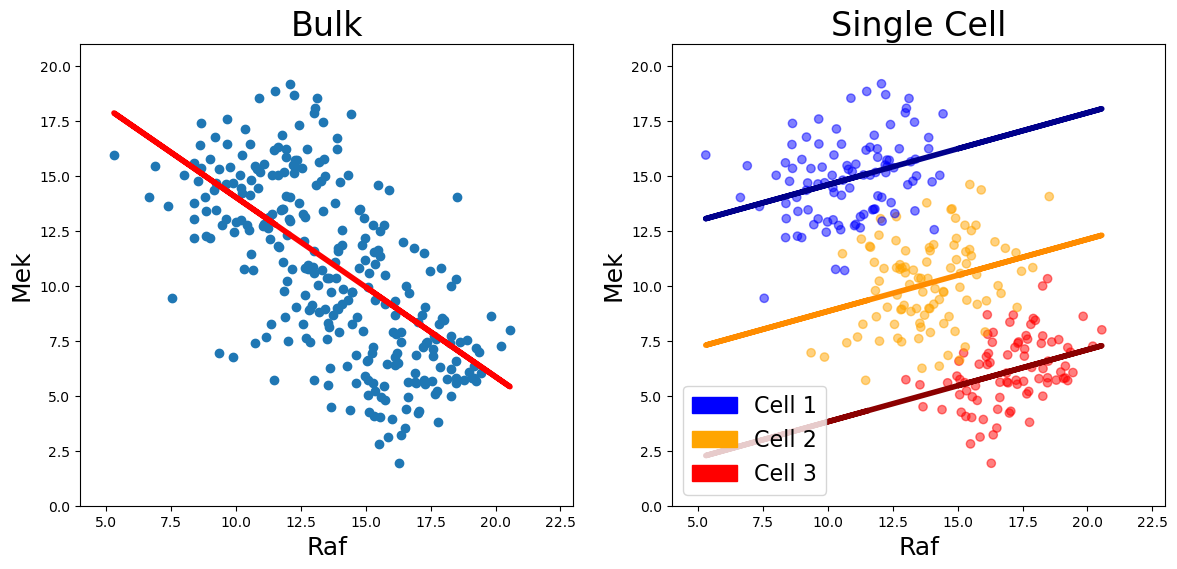

In [251]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(14,6))

colors = np.where(cell_sim_protein_data["cell_type"] == "0", "Red", 
                  np.where(cell_sim_protein_data["cell_type"] == "1", "Orange", "Blue"))

ax[0].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"])
ax[1].scatter(cell_sim_protein_data["Ras"], cell_sim_protein_data["Erk"], 
              c=colors, alpha=.5)

ax[0].plot(cell_sim_protein_data["Ras"], 
           bulk_lm.coef_[0]*cell_sim_protein_data["Ras"] + bulk_lm.intercept_[0], 
           color="red", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[1], 
           color="darkred", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[2], 
           color="darkOrange", lw=4)
ax[1].plot(cell_sim_protein_data["Ras"], 
           single_cell_lm.coef_[0]*cell_sim_protein_data["Ras"] + \
           single_cell_lm.intercept_ + single_cell_lm.coef_[3], 
           color="darkBlue", lw=4)

red_patch = mpatches.Patch(color='red', label='Cell 3')
orange_patch = mpatches.Patch(color='orange', label='Cell 2')
blue_patch = mpatches.Patch(color='blue', label='Cell 1')

ax[1].legend(handles=[blue_patch, orange_patch, red_patch], fontsize=16, loc="lower left")

ax[0].set_xlim(4,23)
ax[1].set_xlim(4,23)
ax[0].set_ylim(0,21)
ax[1].set_ylim(0,21)

ax[0].set_title("Bulk", fontsize=24)
ax[1].set_title("Single Cell", fontsize=24)

ax[0].set_xlabel("Raf", fontsize=18)
ax[1].set_xlabel("Raf", fontsize=18)

ax[0].set_ylabel("Mek", fontsize=18)
ax[1].set_ylabel("Mek", fontsize=18)

# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)

### Run inference

In [255]:
datasets = {"Cell1" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "0"].iloc[:,1:-1], 
            "Cell2" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "1"].iloc[:,1:-1],
            "Cell3" : cell_sim_protein_data[cell_sim_protein_data["cell_type"] == "2"].iloc[:,1:-1]}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Cell 3 Invervention')

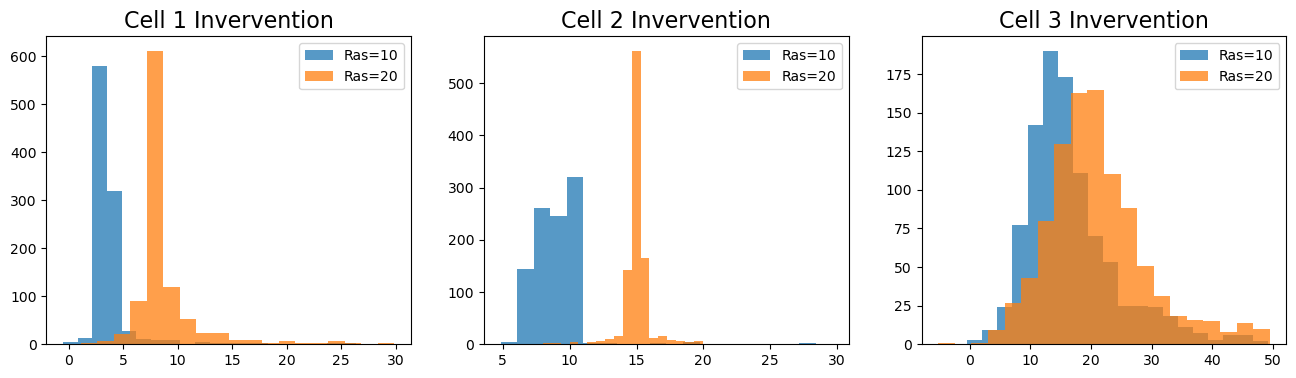

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

ax[0].hist(np.array(intervention_results["Cell1"][0])[np.array(intervention_results["Cell1"][0])<30], label="Ras=10", alpha=.75, bins=20)
ax[0].hist(np.array(intervention_results["Cell1"][1])[np.array(intervention_results["Cell1"][1])<30], label="Ras=20", alpha=.75, bins=20)
ax[0].legend()
ax[1].hist(np.array(intervention_results["Cell2"][0])[np.array(intervention_results["Cell2"][0])<30], label="Ras=10", alpha=.75, bins=20)
ax[1].hist(np.array(intervention_results["Cell2"][1])[np.array(intervention_results["Cell2"][1])<20], label="Ras=20", alpha=.75, bins=20)
ax[1].legend()
ax[2].hist(np.array(intervention_results["Cell3"][0])[np.array(intervention_results["Cell3"][0])<50], label="Ras=10", alpha=.75, bins=20)
ax[2].hist(np.array(intervention_results["Cell3"][1])[np.array(intervention_results["Cell3"][1])<50], label="Ras=20", alpha=.75, bins=20)
ax[2].legend()

ax[0].set_title("Cell 1 Invervention", fontsize=16)
ax[1].set_title("Cell 2 Invervention", fontsize=16)
ax[2].set_title("Cell 3 Invervention", fontsize=16)
# ax[0].set_xlim(-5, 30)
# ax[1].set_xlim(-5, 30)
# ax[2].set_xlim(-5, 30)

In [284]:
np.mean(np.array(intervention_results["Cell1"][1])) - np.mean(np.array(intervention_results["Cell1"][0]))

5.0904074

In [285]:
np.mean(np.array(intervention_results["Cell2"][1])) - np.mean(np.array(intervention_results["Cell2"][0]))

6.08515

In [286]:
np.mean(np.array(intervention_results["Cell3"][1])) - np.mean(np.array(intervention_results["Cell3"][0]))

3.925583

## Low vs High Replicates

Compare causal effect estimation using different numbers of replicates.

### Simulate Data

In [5]:
low_rep_data = simulate_data(graph, coefficients=coef, include_missing=True, n=10, seed=0)
med_rep_data = simulate_data(graph, coefficients=coef, include_missing=True, n=50, seed=0)
high_rep_data = simulate_data(graph, coefficients=coef, include_missing=True, n=250, seed=0)
very_high_rep_data = simulate_data(graph, coefficients=coef, include_missing=True, n=1000, seed=0)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...


In [11]:
low_rep_data["Feature_data"].to_csv("../data/IGF_pathway/low_rep_feature_data.csv", index=False)
med_rep_data["Feature_data"].to_csv("../data/IGF_pathway/med_rep_feature_data.csv", index=False)
high_rep_data["Feature_data"].to_csv("../data/IGF_pathway/high_rep_feature_data.csv", index=False)
very_high_rep_data["Feature_data"].to_csv("../data/IGF_pathway/very_high_rep_feature_data.csv", index=False)

In [287]:
low_rep_protein_data = pd.read_csv("../data/IGF_pathway/low_rep_protein_data.csv")
med_rep_protein_data = pd.read_csv("../data/IGF_pathway/med_rep_protein_data.csv")
high_rep_protein_data = pd.read_csv("../data/IGF_pathway/high_rep_protein_data.csv")
very_high_protein_data = pd.read_csv("../data/IGF_pathway/very_high_rep_protein_data.csv")

## Initial Analysis

Text(0, 0.5, 'Mek')

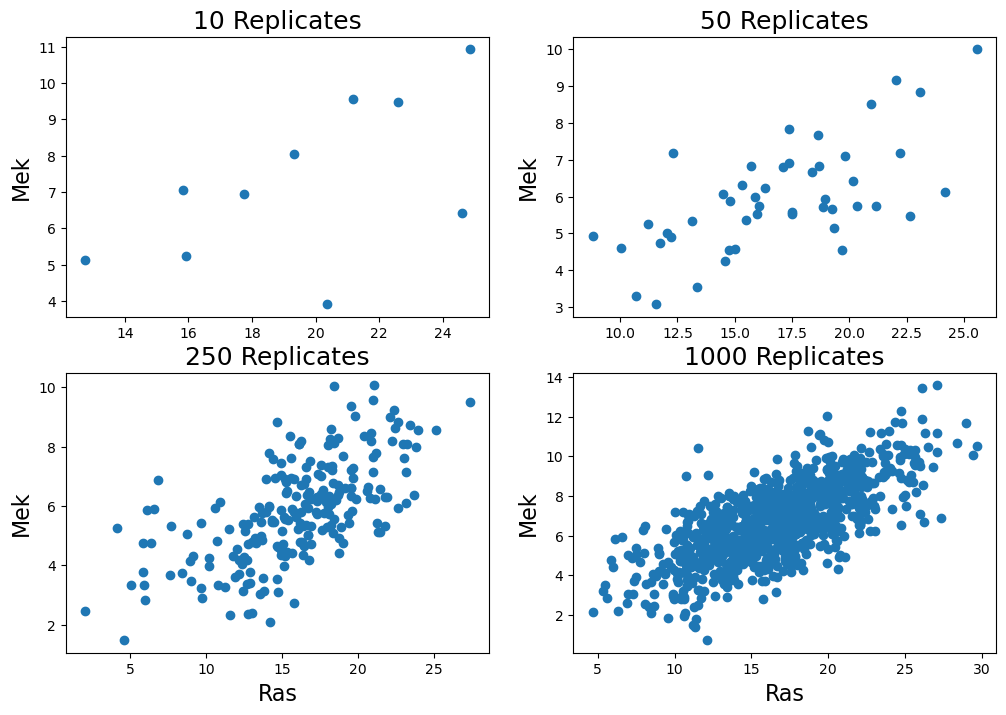

In [293]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

ax[0,0].scatter(low_rep_protein_data["Ras"], low_rep_protein_data["Mek"])
ax[0,1].scatter(med_rep_protein_data["Ras"], med_rep_protein_data["Mek"])
ax[1,0].scatter(high_rep_protein_data["Ras"], high_rep_protein_data["Mek"])
ax[1,1].scatter(very_high_protein_data["Ras"], very_high_protein_data["Mek"])

ax[0,0].set_title("10 Replicates", fontsize=18)
ax[0,1].set_title("50 Replicates", fontsize=18)
ax[1,0].set_title("250 Replicates", fontsize=18)
ax[1,1].set_title("1000 Replicates", fontsize=18)

# ax[0,0].set_xlabel("Raf", fontsize=16)
# ax[0,1].set_xlabel("Raf", fontsize=16)
ax[1,0].set_xlabel("Ras", fontsize=16)
ax[1,1].set_xlabel("Ras", fontsize=16)

ax[0,0].set_ylabel("Mek", fontsize=16)
ax[0,1].set_ylabel("Mek", fontsize=16)
ax[1,0].set_ylabel("Mek", fontsize=16)
ax[1,1].set_ylabel("Mek", fontsize=16)

### Run inference

In [295]:
datasets = {"low" : low_rep_protein_data, "med" : med_rep_protein_data, 
            "high" : high_rep_protein_data, "very_high" : very_high_protein_data}

intervention_results = dict()

for name, data in datasets.items():
    scm = SCM(data, y0_graph_bulk)
    scm.prepare_scm_input()
    scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)
    
    scm.intervention("Ras", "Erk", 10)
    first_int = scm.intervention_samples
    
    scm.intervention("Ras", "Erk", 20)
    second_int = scm.intervention_samples
    
    intervention_results[name] = [first_int, second_int, scm]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

### Compare to ground truth

Text(0.5, 0, 'Log Intensity')

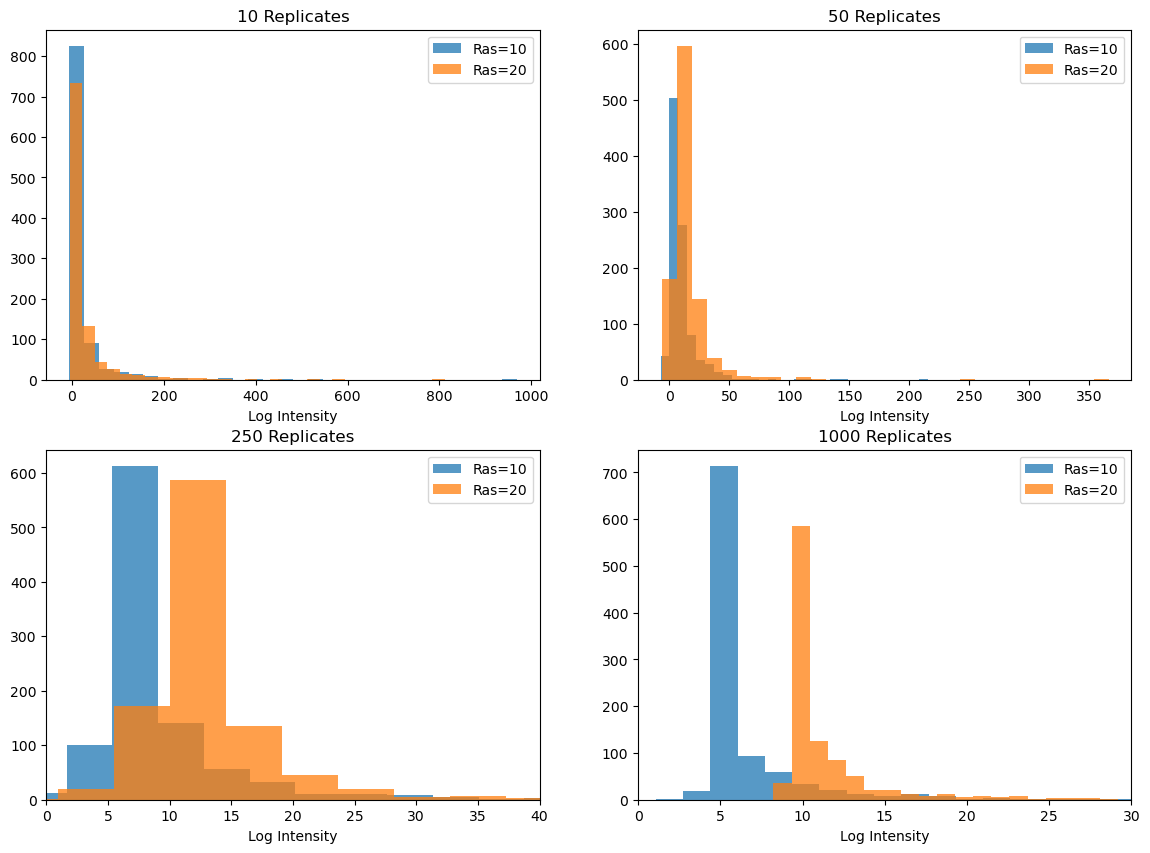

In [297]:
fig, ax = plt.subplots(2, 2, figsize=(14,10))

ax[0,0].hist(intervention_results["low"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,0].hist(intervention_results["low"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,0].legend()

ax[0,1].hist(intervention_results["med"][0], label="Ras=10", alpha=.75, bins=30)
ax[0,1].hist(intervention_results["med"][1], label="Ras=20", alpha=.75, bins=30)
# ax[0,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[0,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0,1].legend()

ax[1,0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[1,0].legend()

ax[1,1].hist(intervention_results["very_high"][0], label="Ras=10", alpha=.75, bins=30)
ax[1,1].hist(intervention_results["very_high"][1], label="Ras=20", alpha=.75, bins=30)
# ax[1,1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
# ax[1,1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[1,1].legend()

ax[1,0].set_xlim(0,40)
ax[1,1].set_xlim(0,30)

plt.legend()
ax[0,0].set_title("10 Replicates")
ax[0,1].set_title("50 Replicates")
ax[1,0].set_title("250 Replicates")
ax[1,1].set_title("1000 Replicates")

ax[0,0].set_xlabel("Log Intensity")
ax[0,1].set_xlabel("Log Intensity")
ax[1,0].set_xlabel("Log Intensity")
ax[1,1].set_xlabel("Log Intensity")

## Missingness

### Simulate Data

In [27]:
high_missing_data = simulate_data(graph, coefficients=coef, include_missing=True, 
                                  mar_missing_param=.1, mnar_missing_param=[-3, .15], 
                                  n=250, seed=0)

simulating data...
adding feature level data...
masking data...


In [28]:
high_missing_data["Feature_data"].to_csv("../data/IGF_pathway/high_missing_feature_data.csv", index=False)

In [29]:
high_missing_protein_data = pd.read_csv("../data/IGF_pathway/high_missing_protein_data.csv")

### Initial Analysis

Text(0.5, 1.0, 'MNAR Curve - High missing prob')

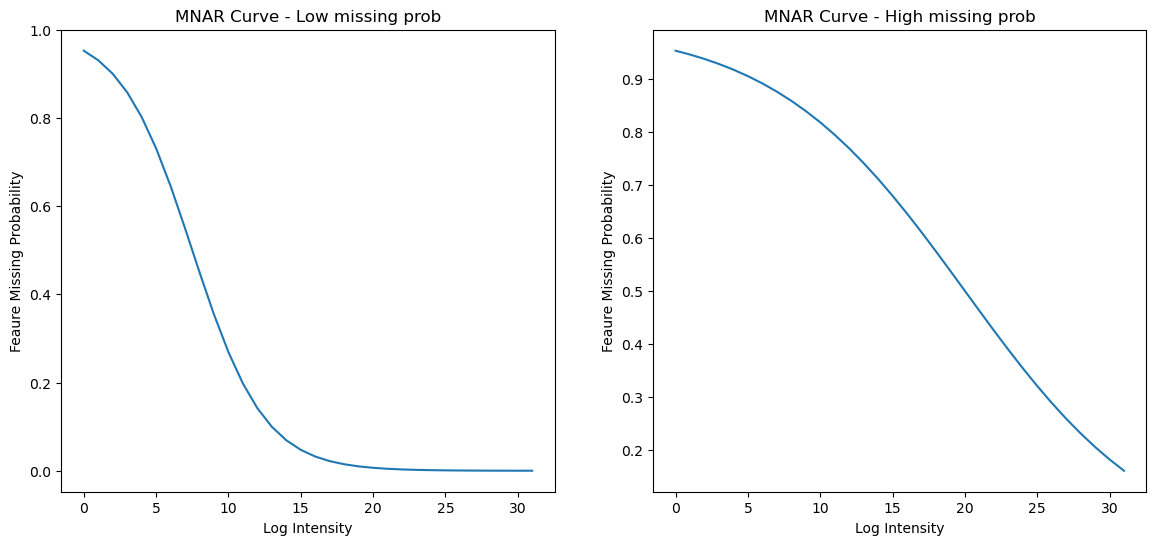

In [79]:
fig, ax = plt.subplots(1,2,figsize=(14,6))


mnar_thresh = [1 / (1 + np.exp(-3 + (.4 * i))) for i in range(0, 32)]
ax[0].plot(mnar_thresh)

mnar_thresh = [1 / (1 + np.exp(-3 + (.15 * i))) for i in range(0, 32)]
ax[1].plot(mnar_thresh)

ax[0].set_xlabel("Log Intensity")
ax[1].set_xlabel("Log Intensity")

ax[0].set_ylabel("Feaure Missing Probability")
ax[1].set_ylabel("Feaure Missing Probability")

ax[0].set_title("MNAR Curve - Low missing prob")
ax[1].set_title("MNAR Curve - High missing prob")

Text(0, 0.5, 'Missing Replicates')

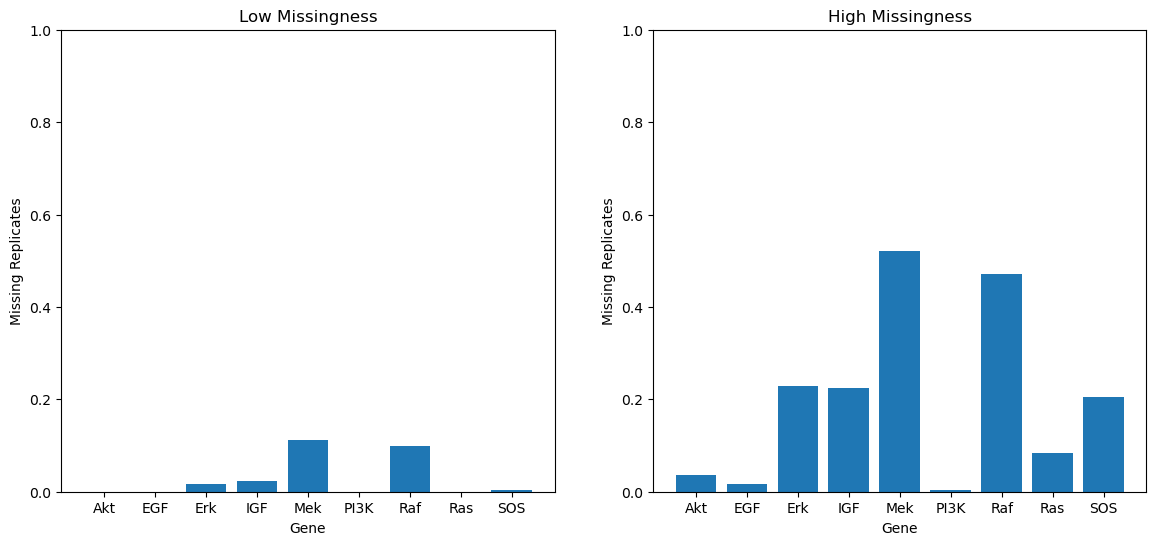

In [72]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax[0].bar(x = high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index,
          height=high_rep_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_rep_protein_data))

ax[1].bar(x = high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0).index, 
       height=high_missing_protein_data.iloc[: ,1:].isnull().sum(axis = 0) / len(high_missing_protein_data))

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[0].set_title("Low Missingness")
ax[1].set_title("High Missingness")

ax[0].set_xlabel("Gene")
ax[1].set_xlabel("Gene")

ax[0].set_ylabel("Missing Replicates")
ax[1].set_ylabel("Missing Replicates")

Text(0, 0.5, 'Mek')

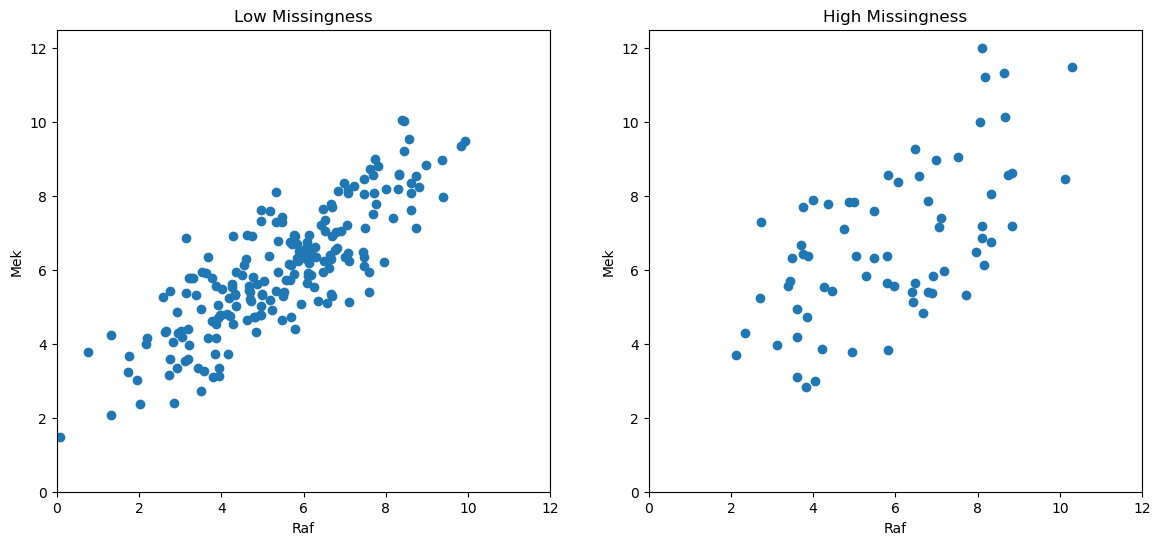

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"])
ax[1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"])

ax[0].set_xlim(0,12)
ax[1].set_xlim(0,12)
ax[0].set_ylim(0,12.5)
ax[1].set_ylim(0,12.5)

ax[0].set_title("Low Missingness")
ax[1].set_title("High Missingness")

ax[0].set_xlabel("Raf")
ax[1].set_xlabel("Raf")

ax[0].set_ylabel("Mek")
ax[1].set_ylabel("Mek")

### Run inference

In [48]:
scm = SCM(high_missing_protein_data, y0_graph)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)

scm.intervention("Ras", "Erk", 10)
first_int = scm.intervention_samples

scm.intervention("Ras", "Erk", 20)
second_int = scm.intervention_samples

high_missing_intervention_results = [first_int, second_int]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Text(0.5, 0, 'Log Intensity')

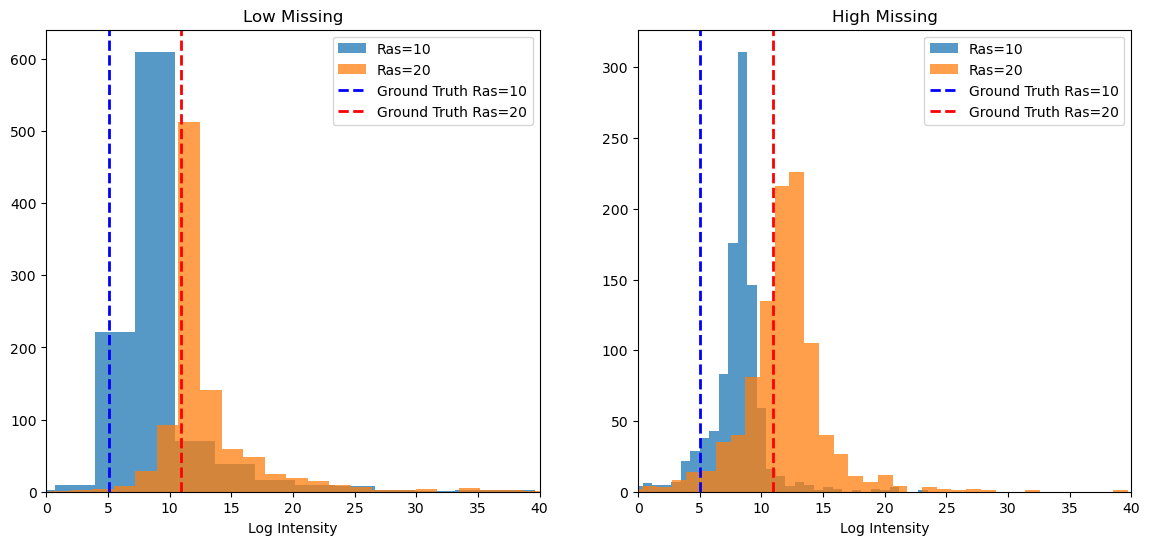

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(intervention_results["high"][0], label="Ras=10", alpha=.75, bins=40)
ax[0].hist(intervention_results["high"][1], label="Ras=20", alpha=.75, bins=40)
ax[0].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
ax[0].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[0].legend()

ax[1].hist(high_missing_intervention_results[0], label="Ras=10", alpha=.75, bins=40)
ax[1].hist(high_missing_intervention_results[1], label="Ras=20", alpha=.75, bins=40)
ax[1].axvline(x=np.mean(gt_int_data[0]), color="Blue", lw=2, linestyle="--", label="Ground Truth Ras=10")
ax[1].axvline(x=np.mean(gt_int_data[1]), color="Red", lw=2, linestyle="--", label="Ground Truth Ras=20")
ax[1].legend()

ax[0].set_xlim(0,40)
ax[1].set_xlim(0,40)

plt.legend()
ax[0].set_title("Low Missing")
ax[1].set_title("High Missing")

ax[0].set_xlabel("Log Intensity")
ax[1].set_xlabel("Log Intensity")

### Checkout simulated data

In [92]:
mek_imp = scm.summary_stats["imp_Mek"]["mean"]
raf_imp = scm.summary_stats["imp_Raf"]["mean"]

## Add in missing data
high_missing_protein_data.loc[:, "imp_Mek"] = high_missing_protein_data.loc[:, "Mek"].isna()
high_missing_protein_data.loc[:, "imp_Raf"] = high_missing_protein_data.loc[:, "Raf"].isna()
high_missing_protein_data.loc[:, "full_Mek"] = high_missing_protein_data.loc[:, "Mek"]
high_missing_protein_data.loc[:, "full_Raf"] = high_missing_protein_data.loc[:, "Raf"]

high_missing_protein_data.loc[high_missing_protein_data["imp_Mek"], "full_Mek"] = mek_imp
high_missing_protein_data.loc[high_missing_protein_data["imp_Raf"], "full_Raf"] = raf_imp

In [100]:
high_missing_protein_data

0      False
1      False
2       True
3      False
4      False
       ...  
245    False
246     True
247    False
248    False
249    False
Length: 250, dtype: bool

Text(0, 0.5, 'Mek')

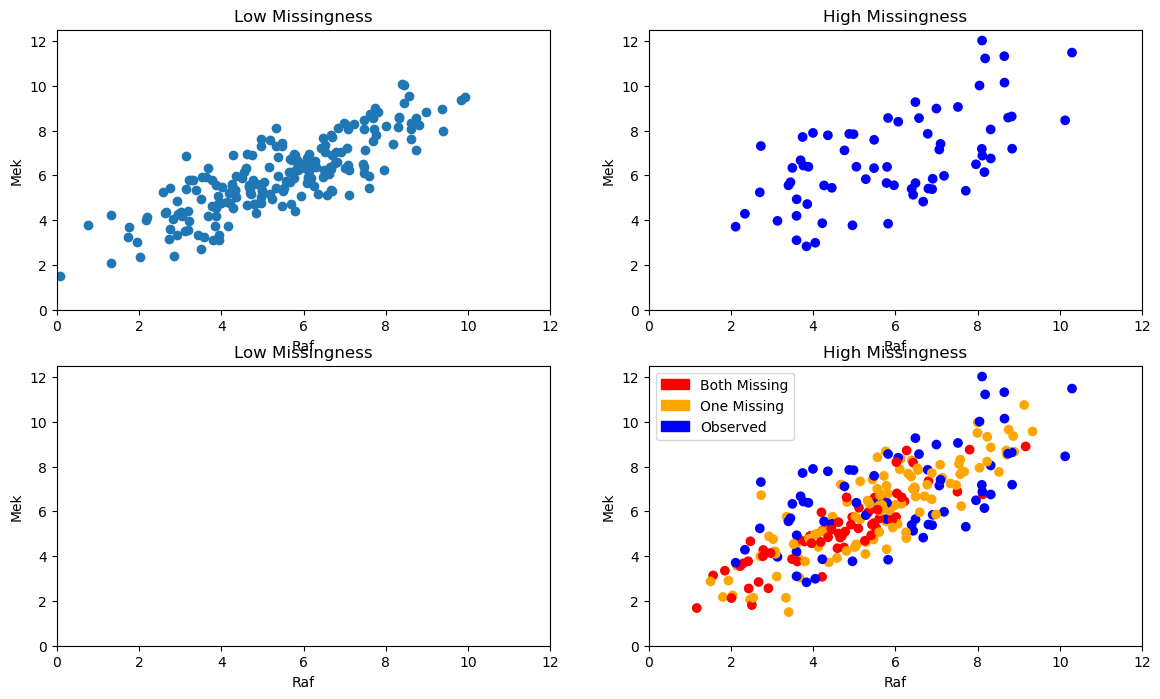

In [115]:
## Plot
fig, ax = plt.subplots(2, 2, figsize=(14,8))

colors = np.where((high_missing_protein_data["imp_Mek"] == True) & \
                   (high_missing_protein_data["imp_Raf"] == True), "Red", 
                  np.where((high_missing_protein_data["imp_Raf"] == True) | \
                           (high_missing_protein_data["imp_Mek"] == True), "Orange", "Blue"))

ax[0,0].scatter(high_rep_protein_data["Raf"], high_rep_protein_data["Mek"])
ax[0,1].scatter(high_missing_protein_data["Raf"], high_missing_protein_data["Mek"], 
              c=colors)

ax[1,1].scatter(high_missing_protein_data["full_Raf"], high_missing_protein_data["full_Mek"], 
              c=colors)

red_patch = mpatches.Patch(color='red', label='Both Missing')
orange_patch = mpatches.Patch(color='orange', label='One Missing')
blue_patch = mpatches.Patch(color='blue', label='Observed')

ax[1,1].legend(handles=[red_patch, orange_patch, blue_patch])

ax[0,0].set_xlim(0,12)
ax[1,1].set_xlim(0,12)
ax[0,1].set_xlim(0,12)
ax[1,0].set_xlim(0,12)
ax[0,0].set_ylim(0,12.5)
ax[1,1].set_ylim(0,12.5)
ax[0,1].set_ylim(0,12.5)
ax[1,0].set_ylim(0,12.5)

ax[0,0].set_title("Low Missingness")
ax[1,1].set_title("High Missingness")
ax[1,0].set_title("Low Missingness")
ax[0,1].set_title("High Missingness")

ax[0,0].set_xlabel("Raf")
ax[1,1].set_xlabel("Raf")
ax[1,0].set_xlabel("Raf")
ax[0,1].set_xlabel("Raf")

ax[0,0].set_ylabel("Mek")
ax[1,1].set_ylabel("Mek")
ax[1,0].set_ylabel("Mek")
ax[0,1].set_ylabel("Mek")

# Test network

In [2]:
graph = nx.DiGraph()
graph.add_edge("EGF", "SOS")

all_nodes = ["SOS", "EGF"]
obs_nodes = ["SOS", "EGF"]
latent_nodes = []
attrs = {node: (True if node not in obs_nodes and 
                node != "\\n" else False) for node in all_nodes}

nx.set_node_attributes(graph, attrs, name="hidden")

In [3]:
simplified_graph = simplify_latent_dag(graph, "hidden")
y0_graph = y0.graph.NxMixedGraph()
y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")

In [4]:
n = 1000

EGF = np.random.normal(15, 4, n)
SOS = 5. + (2.*EGF) + np.random.normal(0, 1., n)

sim_data = pd.DataFrame(data=np.array([SOS,EGF]).T, 
                        columns=["SOS", "EGF"])

In [5]:
scm = SCM(sim_data, y0_graph)
scm.prepare_scm_input()
scm.fit_scm("SVI", num_steps=2500, initial_lr=.01, gamma=.01)

starting training
3838906899.305622
2874163.1727313194
22380.733880892072
8295.250773514543
9369.172553231907
6128.126815074451
5347.146247713429
5489.8089623792885
8039.930955844344
15430.373784930562
19674.429679428154
19747.125572330733
32359.832923758546
5974.654421943999
16194.53340575249
6294.142931689465
4919.723042263397
5694.861740190177
7194.476056146203
665761.0655298568
5156.591661292239
5616.443847916282
4532.000667569366
4578.623280398982
5546.547666823187


In [6]:
scm.learned_params

{'EGF_mean_mean_param': tensor(14.4713),
 'EGF_mean_scale_param': tensor(0.5341),
 'EGF_scale_param': tensor(0.1718),
 'SOS_intercept_mean_param': tensor(5.8957),
 'SOS_intercept_scale_param': tensor(0.7221),
 'SOS_EGF_coef_mean_param': tensor(1.9428),
 'SOS_EGF_coef_scale_param': tensor(0.0549),
 'SOS_scale_param': tensor(0.4536)}

In [7]:
scm.intervention("EGF", 20.)

In [37]:
# Posterior samples
post_samples = [scm.model(None, scm.root_nodes, scm.descendent_nodes, [], scm.learned_params)["SOS"] for i in range(1000)]

intervened_model = pyro.do(scm.model, data={"EGF": torch.tensor(20.)})
int_samples = [intervened_model(None, scm.root_nodes, scm.descendent_nodes, [], scm.learned_params)["SOS"] for i in range(1000)]

(array([  1.,   0.,   0.,   0.,   1.,   3.,   0.,   5.,   7.,  22.,  48.,
        147., 549., 139.,  38.,  16.,  13.,   6.,   1.,   4.]),
 array([-55.1634407 , -49.56267929, -43.96191406, -38.36115265,
        -32.76039124, -27.15962982, -21.5588665 , -15.95810413,
        -10.35734177,  -4.7565794 ,   0.84418297,   6.44494534,
         12.0457077 ,  17.64646912,  23.24723244,  28.84799576,
         34.44875717,  40.04951859,  45.65028381,  51.25104523,
         56.85180664]),
 <BarContainer object of 20 artists>)

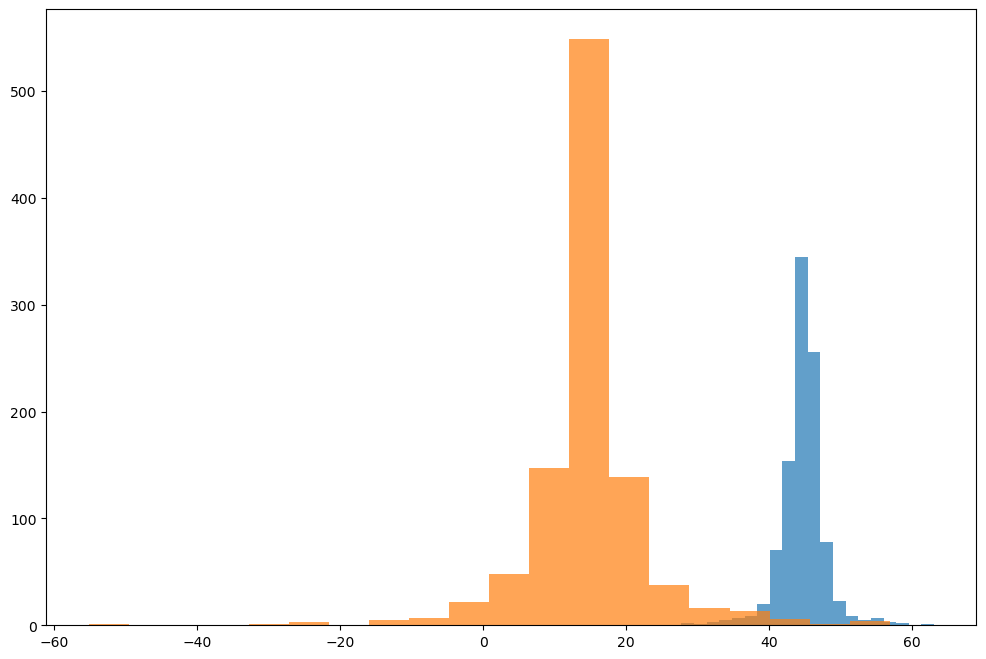

In [9]:
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(np.array(scm.intervention_samples), bins=20, alpha=.7)
ax.hist(np.array(scm.posterior_samples), bins=20, alpha=.7)

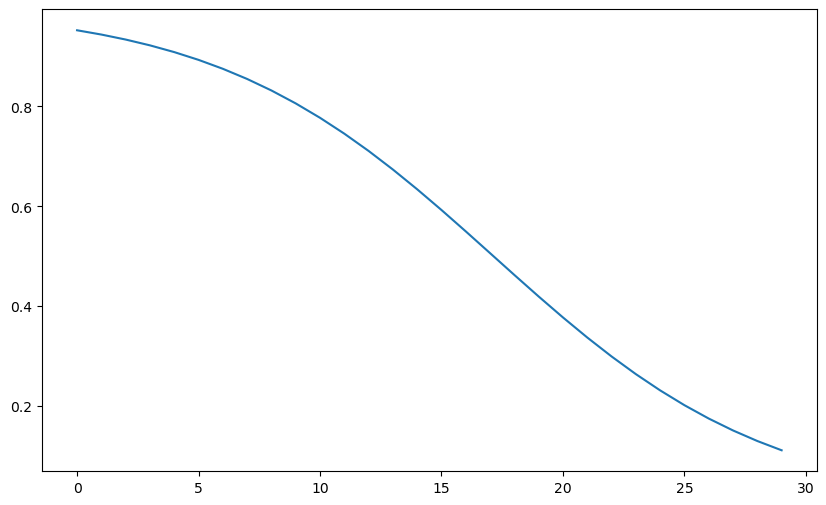

In [21]:
fig, ax = plt.subplots(figsize=(10,6))


mnar_thresh = [1 / (1 + np.exp(-3 + (.175 * i))) for i in range(0, 30)]
ax.plot(mnar_thresh)

In [17]:
pickle_filename = '../data/IGF_pathway/IGF_sim_data_10_reps.pkl'
with open(pickle_filename, 'rb') as pickle_file:
    sim_data = pickle.load(pickle_file)

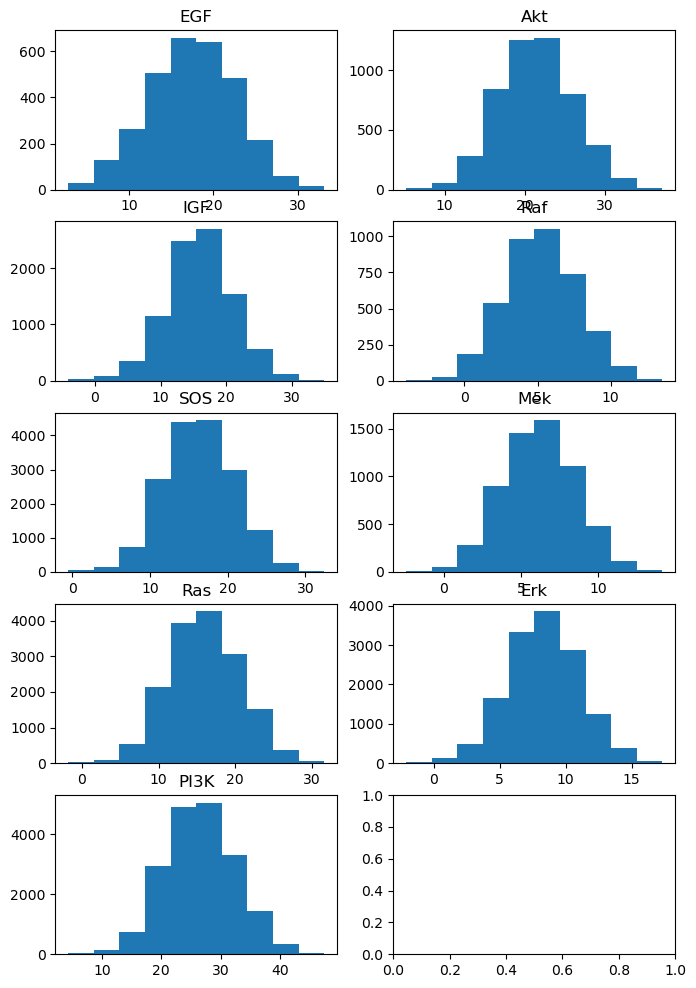

In [18]:
feat_data = sim_data["Feature_data"]
prot = feat_data["Protein"].unique()

fig, ax = plt.subplots(5, 2, figsize=(8,12))

for i in range(5):
    data0 = feat_data[feat_data["Protein"] == prot[i]]["Intensity"]
    ax[i, 0].hist(data0)
    ax[i, 0].set_title(prot[i])
    try:
        data1 = feat_data[feat_data["Protein"] == prot[i+5]]["Intensity"]
        ax[i, 1].hist(data1)
        ax[i, 1].set_title(prot[i+5])
    except:
        pass
    

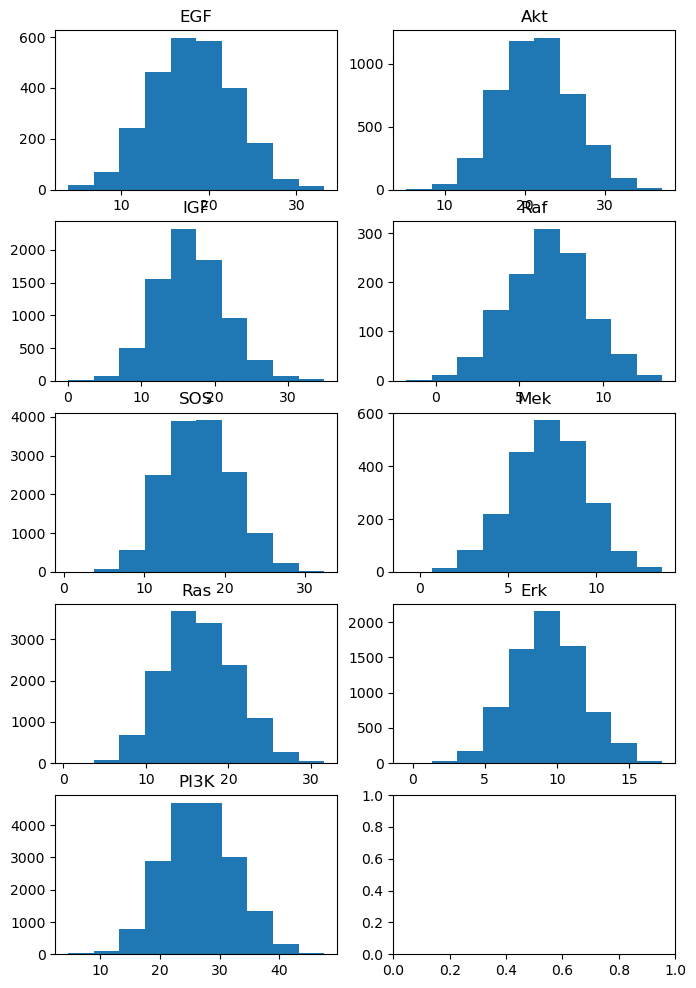

In [19]:
feat_data = sim_data["Feature_data"]
prot = feat_data["Protein"].unique()

fig, ax = plt.subplots(5, 2, figsize=(8,12))

for i in range(5):
    data0 = feat_data[feat_data["Protein"] == prot[i]]["Obs_Intensity"]
    ax[i, 0].hist(data0)
    ax[i, 0].set_title(prot[i])
    try:
        data1 = feat_data[feat_data["Protein"] == prot[i+5]]["Obs_Intensity"]
        ax[i, 1].hist(data1)
        ax[i, 1].set_title(prot[i+5])
    except:
        pass
    

In [128]:
feat_data.to_csv("../data/IGF_pathway/feature_data.csv", index=False)

In [4]:
sim_data = pd.read_csv("../data/IGF_pathway/protein_data.csv")
sim_data = sim_data.drop(columns="originalRUN")

In [5]:
scm = SCM(sim_data, y0_graph)
scm.prepare_scm_input()
scm.fit_scm(num_samples=1000, warmup_steps=3000, num_chains=4)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
scm.summary_stats

{'Akt_PI3K_coef': OrderedDict([('mean', 0.7553782),
              ('std', 0.006031862),
              ('median', 0.7553748),
              ('5.0%', 0.74544924),
              ('95.0%', 0.76511884),
              ('n_eff', 3432.5203119341963),
              ('r_hat', 1.0004874775557149)]),
 'Akt_intercept': OrderedDict([('mean', 0.88367987),
              ('std', 0.1652224),
              ('median', 0.88067883),
              ('5.0%', 0.60136026),
              ('95.0%', 1.1394776),
              ('n_eff', 3296.886473180407),
              ('r_hat', 1.0003674736860562)]),
 'Akt_scale': OrderedDict([('mean', 1.1274117),
              ('std', 0.025183002),
              ('median', 1.1267402),
              ('5.0%', 1.0865678),
              ('95.0%', 1.169877),
              ('n_eff', 5315.196261445477),
              ('r_hat', 0.9991049186467084)]),
 'Erk_Mek_coef': OrderedDict([('mean', 1.218066),
              ('std', 0.017896896),
              ('median', 1.2183089),
              ('5

In [12]:
scm.learned_params

{'Akt_PI3K_coef_mean_param': Array(0.4262519, dtype=float32),
 'Akt_PI3K_coef_scale_param': Array(0.0151993, dtype=float32),
 'Akt_intercept_mean_param': Array(9.497036, dtype=float32),
 'Akt_intercept_scale_param': Array(0.40243462, dtype=float32),
 'Akt_scale_param': Array(1.1230582, dtype=float32),
 'Erk_Mek_coef_mean_param': Array(0.9949813, dtype=float32),
 'Erk_Mek_coef_scale_param': Array(0.01368082, dtype=float32),
 'Erk_intercept_mean_param': Array(2.1536965, dtype=float32),
 'Erk_intercept_scale_param': Array(0.09390368, dtype=float32),
 'Erk_scale_param': Array(1.0391563, dtype=float32),
 'Mek_Raf_coef_mean_param': Array(1.1010401, dtype=float32),
 'Mek_Raf_coef_scale_param': Array(0.02437793, dtype=float32),
 'Mek_intercept_mean_param': Array(0.30297956, dtype=float32),
 'Mek_intercept_scale_param': Array(0.14352387, dtype=float32),
 'Mek_scale_param': Array(1.2503028, dtype=float32),
 'PI3K_Ras_coef_mean_param': Array(1.2041326, dtype=float32),
 'PI3K_Ras_coef_scale_param'

In [7]:
import numpyro

intervened_model = numpyro.handlers.do(scm.model, data={"Ras": 10})
int_samples = [intervened_model(None, scm.root_nodes, scm.descendent_nodes,
                                [], scm.learned_params)["Erk"] for _ in range(1000)]

intervened_model = numpyro.handlers.do(scm.model, data={"Ras": 20})
int_samples2 = [intervened_model(None, scm.root_nodes, scm.descendent_nodes,
                                [], scm.learned_params)["Erk"] for _ in range(1000)]


In [8]:
np.mean(int_samples)

8.225936

In [9]:
np.mean(int_samples2)

12.344701

In [10]:
coef = {'EGF': {'intercept': 18.},
         'SOS': {'EGF': 0.6,
          'IGF': 0.6,
          'intercept': -4},
         'PI3K': {'EGF': .5,
          'IGF': 0.5,
          'Ras': .5,
          'intercept': 1.6},
         'IGF': {'intercept': 16.},
         'Ras': {'SOS': 1., 'intercept': -0.5},
         'Raf': {'Ras': 0.8,
          'Akt': -.4,
          'intercept': 1.75},
         'Akt': {'PI3K': 0.75, 'intercept': 2.},
         'Mek': {'Raf': 0.75, 'intercept': 2.},
         'Erk': {'Mek': 1.2, 'intercept': 1.}}
    
def calc_true_ace(coef):
    n = 1000

    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_obs = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = 20.
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_int = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    return [Erk_obs, Erk_int]

true = calc_true_ace(coef)

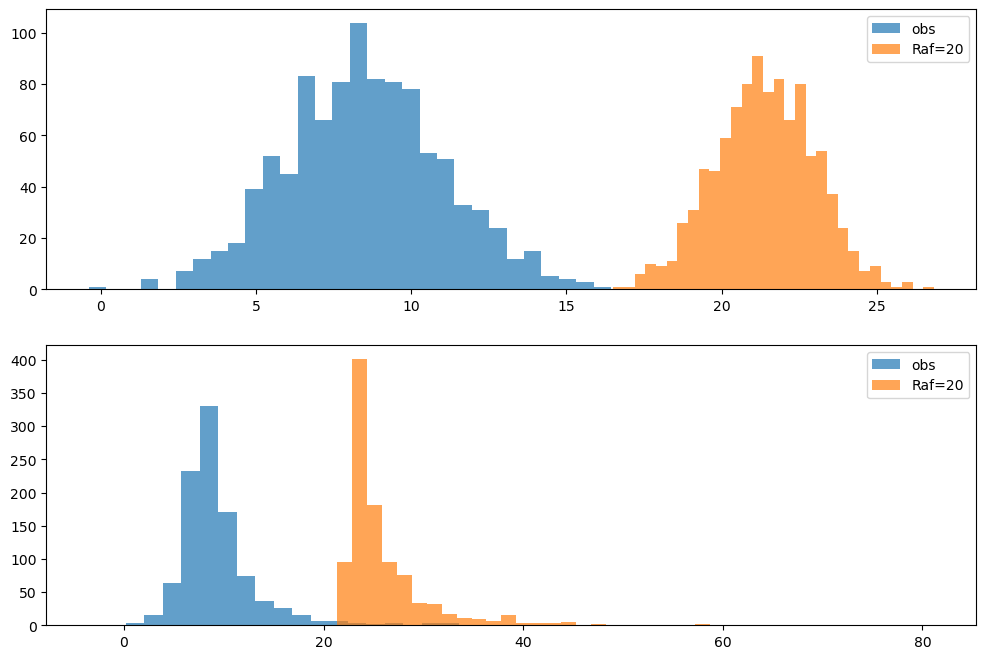

In [12]:
fig, ax = plt.subplots(2,1,figsize=(12,8))

ax[0].hist(np.array(true[0]), bins=30, alpha=.7, label="obs")
ax[0].hist(np.array(true[1]), bins=30, alpha=.7, label="Raf=20")
ax[0].legend()

ax[1].hist(np.array([i["Erk"] for i in scm.posterior_samples]), bins=40, alpha=.7, label="obs")
ax[1].hist(np.array(scm.intervention_samples), bins=40, alpha=.7, label="Raf=20")
ax[1].legend()

In [11]:
def calc_true_ace(coef):
    n = 1000

    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 10
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_obs = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = 20
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk_int = coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    
    return [Erk_obs, Erk_int]
vals=calc_true_ace(coef)

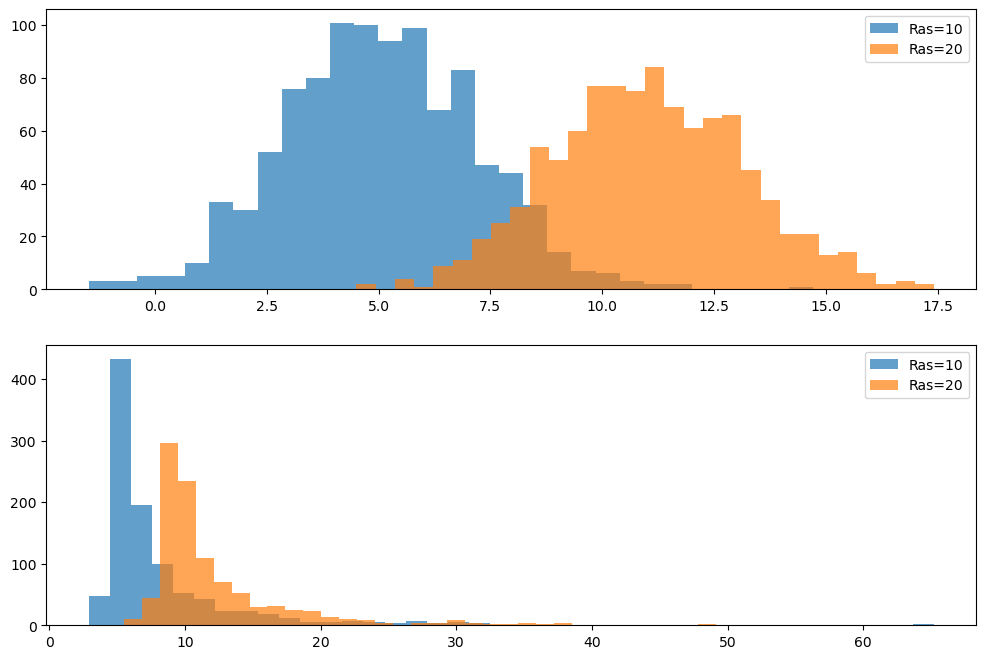

In [12]:
fig, ax = plt.subplots(2,1,figsize=(12,8))

ax[0].hist(np.array(vals[0]), bins=30, alpha=.7, label="Ras=10")
ax[0].hist(np.array(vals[1]), bins=30, alpha=.7, label="Ras=20")
ax[0].legend()

ax[1].hist(np.array(int_samples), bins=40, alpha=.7, label="Ras=10")
ax[1].hist(np.array(int_samples2), bins=40, alpha=.7, label="Ras=20")
ax[1].legend()

In [96]:
def true_sim(coef):
    n = 1000

    EGF = np.random.normal(coef["EGF"]["intercept"], 5, n)
    IGF = np.random.normal(coef["IGF"]["intercept"], 5, n)

    SOS = coef["SOS"]["intercept"] + coef["SOS"]["EGF"]*EGF + coef["SOS"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Ras = coef["Ras"]["intercept"] + coef["Ras"]["SOS"]*SOS + np.random.normal(0, 1., n)
    PI3K = coef["PI3K"]["intercept"] + coef["PI3K"]["Ras"]*Ras + coef["PI3K"]["EGF"]*EGF + coef["PI3K"]["IGF"]*IGF + np.random.normal(0, 1., n)
    Akt = coef["Akt"]["intercept"] + coef["Akt"]["PI3K"]*PI3K + np.random.normal(0, 1., n)
    Raf = coef["Raf"]["intercept"] + coef["Raf"]["Ras"]*Ras + coef["Raf"]["Akt"]*Akt + np.random.normal(0, 1., n)
    Mek = coef["Mek"]["intercept"] + coef["Mek"]["Raf"]*Raf + np.random.normal(0, 1., n)
    Erk= coef["Erk"]["intercept"] + coef["Erk"]["Mek"]*Mek + np.random.normal(0, 1., n)
    return({"EGF" : EGF, "IGF" : IGF, "SOS" : SOS, "Ras" : Ras, "PI3K": PI3K, "Akt" : Akt,
           "Raf" : Raf, "Mek" : Mek, "Erk" : Erk})

In [97]:
true = true_sim(coef)

In [91]:
pickle_filename = '../data/IGF_pathway/IGF_sim_data.pkl'

# Load the object from the pickle file
with open(pickle_filename, 'rb') as pickle_file:
    data = pickle.load(pickle_file)

In [29]:
data.keys()

dict_keys(['Protein_data', 'Feature_data', 'Coefficients'])

In [92]:
sim_data_original = data['Protein_data']
feature_original = data['Feature_data']

In [35]:
sim_data_test.keys()

Index(['Protein', 'Replicate', 'Feature', 'Intensity', 'Obs_Intensity',
       'MNAR_threshold', 'MAR', 'MNAR'],
      dtype='object')

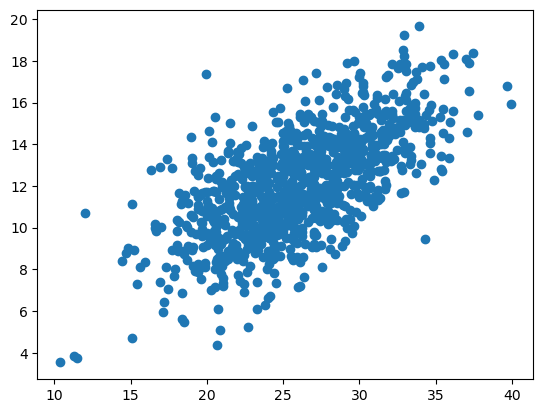

In [93]:
fig, ax = plt.subplots()
sim_data_test = sim_data_test.dropna()
ax.scatter(sim_data_original["Ras"], 
          sim_data_original["Erk"])

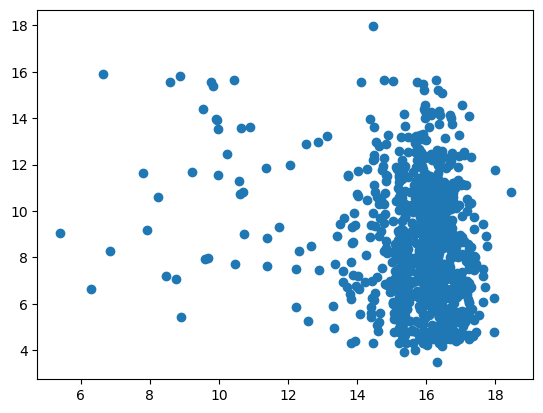

In [80]:
fig, ax = plt.subplots()
ax.scatter(sim_data["Ras"], 
          sim_data["Erk"])

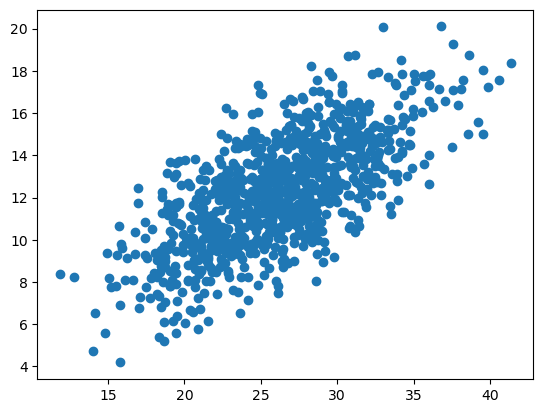

In [90]:
fig, ax = plt.subplots()
ax.scatter(true["Ras"], true["Erk"])

(array([  5.,  24.,  97., 191., 224., 230., 144.,  58.,  19.,   8.]),
 array([11.85330306, 14.80433321, 17.75536337, 20.70639352, 23.65742368,
        26.60845383, 29.55948399, 32.51051414, 35.4615443 , 38.41257445,
        41.36360461]),
 <BarContainer object of 10 artists>)

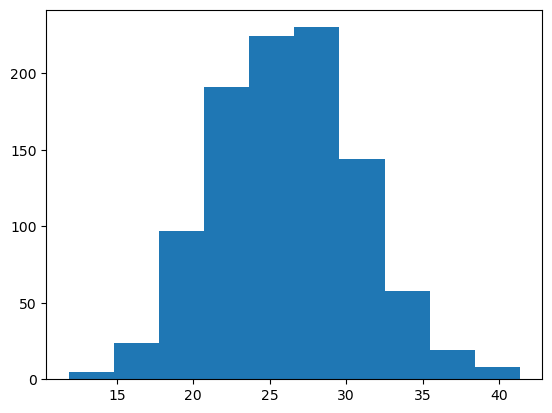

In [89]:
fig, ax = plt.subplots()
ax.hist(true["Ras"])

(array([  13.,   74.,  684., 2221., 3677., 3399., 2376., 1100.,  264.,
          39.]),
 array([ 0.55762545,  3.66317039,  6.76871534,  9.87426029, 12.97980524,
        16.08535018, 19.19089513, 22.29644008, 25.40198502, 28.50752997,
        31.61307492]),
 <BarContainer object of 10 artists>)

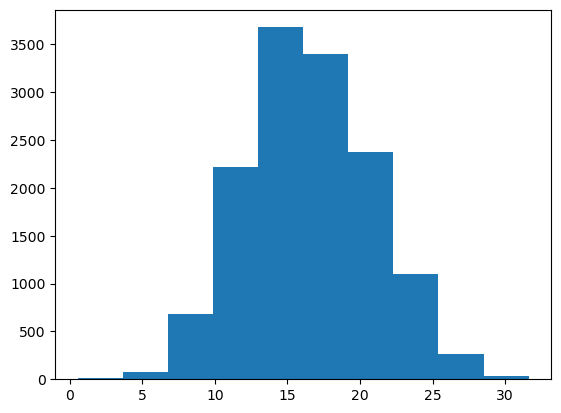

In [83]:
fig, ax = plt.subplots()
ax.hist(feature_original[feature_original["Protein"] == "Ras"]["Obs_Intensity"])

(array([  35.,   90.,  531., 2148., 3946., 4264., 3056., 1514.,  370.,
          46.]),
 array([-1.81326219,  1.52937152,  4.87200523,  8.21463894, 11.55727265,
        14.89990636, 18.24254007, 21.58517379, 24.9278075 , 28.27044121,
        31.61307492]),
 <BarContainer object of 10 artists>)

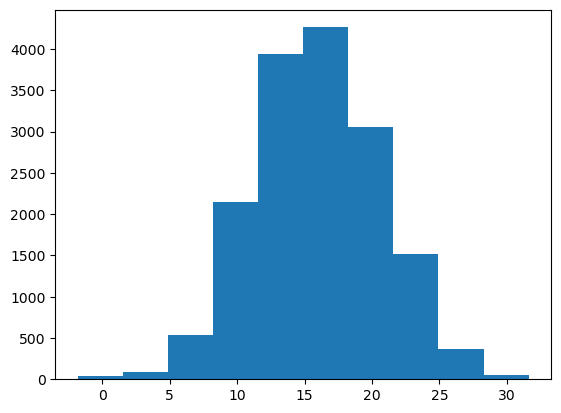

In [84]:
fig, ax = plt.subplots()
ax.hist(feature_original[feature_original["Protein"] == "Ras"]["Intensity"])

(array([  4.,   9.,  46., 141., 240., 239., 184., 100.,  29.,   8.]),
 array([ 0.18025187,  3.13535833,  6.09046479,  9.04557125, 12.00067771,
        14.95578417, 17.91089063, 20.86599709, 23.82110355, 26.77621   ,
        29.73131646]),
 <BarContainer object of 10 artists>)

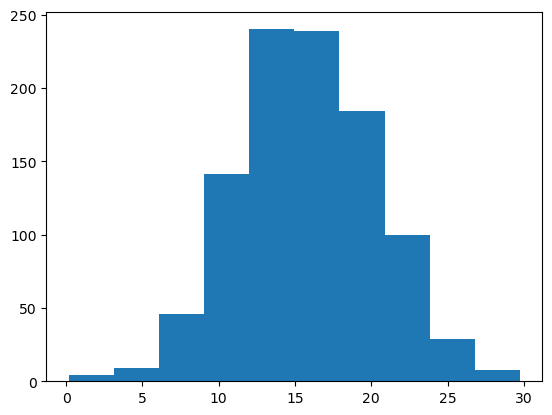

In [85]:

fig, ax = plt.subplots()
ax.hist(sim_data_original["Ras"])